In [1]:
import numpy as np
import matplotlib.pyplot as plt
pi=np.pi

In [2]:
# lets define transition function
n_step = 1000
def angle(s_0,s_1):
    d = s_0-s_1
    d[np.abs(d)>90]-= 180*np.sign(d[np.abs(d)>90])
    return d
def c(s_0,s_1=90,lam=10,gamma=2): ## eq 7
    full = np.exp(-1/(2*lam**2)*np.abs(angle(s_0,s_1))**gamma)
    return full/np.sum(full)

def cf(s_0,s_1=90,lam=10,gamma=2,p_same=0.9): ## eq 6
    return p_same*c(s_0,s_1,lam,gamma) + (1-p_same)*(1/n_step)

def pm(s_0,s_1,sensoryNoise): ## eq. 10
    full = np.exp(-1/(2*sensoryNoise**2)*np.abs(angle(s_0,s_1))**2)
    return full/np.sum(full)
def gauss(x,mu=0,sig=1): return 1/np.sqrt(2*pi*sig**2)*np.exp(-((x-mu)**2)/(2*sig**2)) # for convolution

# Transition Model

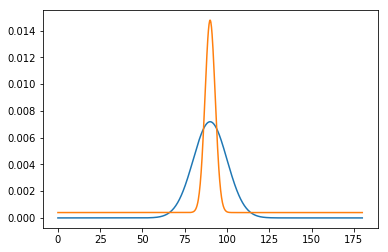

In [3]:
s_1 = 90
s_0 = np.linspace(0,180,n_step)
m0 = cf(s_0,s_1,p_same=1.0)
m1 = cf(s_0,s_1,p_same=0.6,lam=3)
plt.plot(s_0,m0)
plt.plot(s_0,m1)
plt.show()

# Sensory Integration Model

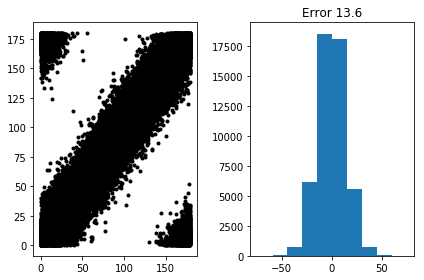

In [4]:
N = 50000
kappa = 5
seq = np.random.randint(0,180,N)
sensory = np.random.vonmises((seq-90)/90*pi,kappa)*90/pi+90
E = sensory-seq
E[np.abs(E)>90]-=180*np.sign(E[np.abs(E)>90])
# sensoryPrev = np.concatenate(([0],sensory[:-1]))
sensoryNoise = np.std(E)


plt.subplot(121)
plt.plot(seq,sensory,'k.')
plt.subplot(122)
plt.hist(E)
plt.title('Error %.1f' %sensoryNoise)
plt.tight_layout()
plt.show()



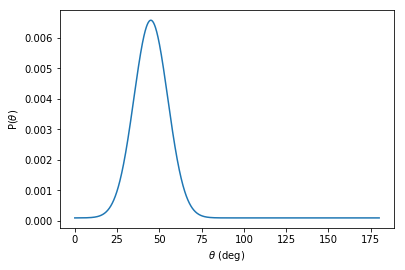

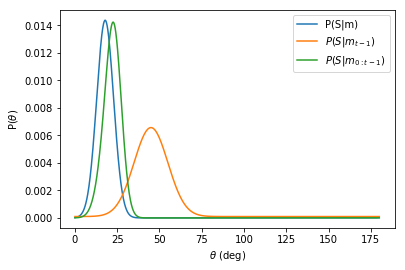

In [8]:
# get posterior 
trial = 2
sensoryNoise = kappa
this_ori = sensory[-10]
prior = cf(s_0,this_ori)
sensory_estimate = pm(s_0,sensory[trial],sensoryNoise)
estimate = sensory_estimate*prior
estimate /=sum(estimate)


plt.plot(s_0,prior)
# plt.plot
# plt.legend(('P(S|m)','$P(S|m_{t-1})$','$P(S|m_{0:t-1})$'))
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('P($\\theta$)')
plt.show()

plt.plot(s_0,sensory_estimate)
plt.plot(s_0,prior)
plt.plot(s_0,estimate)
plt.legend(('P(S|m)','$P(S|m_{t-1})$','$P(S|m_{0:t-1})$'))
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('P($\\theta$)')
plt.show()

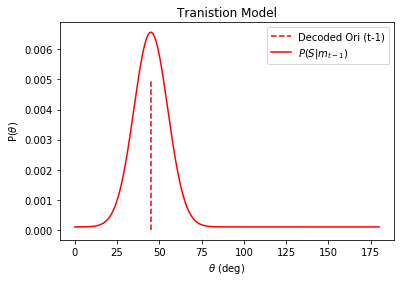

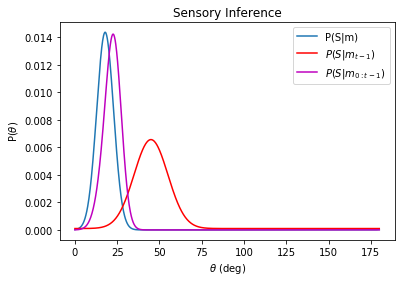

In [16]:
plt.plot([this_ori,this_ori],[0,.005],'r--')
plt.plot(s_0,prior,'r')

plt.legend(('Decoded Ori (t-1)','$P(S|m_{t-1})$'))
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('P($\\theta$)')
plt.title('Tranistion Model')
plt.show()

plt.plot(s_0,sensory_estimate)
plt.plot(s_0,prior,'r')
plt.plot(s_0,estimate,'m')
plt.legend(('P(S|m)','$P(S|m_{t-1})$','$P(S|m_{0:t-1})$'))
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('P($\\theta$)')
plt.title('Sensory Inference')
plt.show()

In [208]:
inferred_ori = np.zeros(N)
for i in range(N):
    if i ==0:
        prior = cf(s_0,sensory[-1]) # need to start with something
    else:
        prior = cf(s_0,inferred_ori[i-1])
    sensory_estimate = pm(s_0,sensory[i],sensoryNoise)
    ps_m = prior * sensory_estimate
    ps_m /= np.sum(ps_m)
    decoded_ori = np.argmax(ps_m) # could use circ_mean
    inferred_ori[i] = s_0[decoded_ori]
E = inferred_ori - seq
E[np.abs(E)>90]-=180*np.sign(E[np.abs(E)>90])

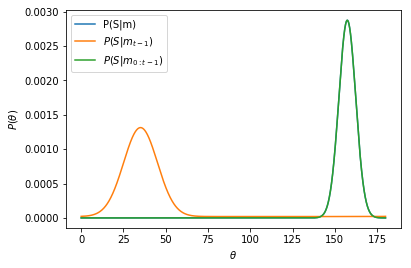

In [209]:
sensory_estimate = pm(s_0,sensory[i],sensoryNoise)
plt.plot(s_0,sensory_estimate)
plt.plot(s_0,prior)
ps_m = prior * sensory_estimate
ps_m /= np.sum(ps_m)
plt.plot(s_0,ps_m)
plt.legend(('P(S|m)','$P(S|m_{t-1})$','$P(S|m_{0:t-1})$'))
plt.xlabel('$\\theta$')
plt.ylabel('$P(\\theta)$')
plt.show()

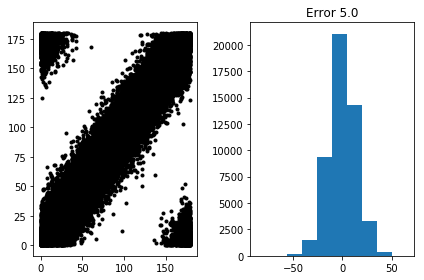

In [210]:
plt.subplot(121)
plt.plot(seq,inferred_ori,'k.')
plt.subplot(122)
plt.hist(E)
plt.title('Error %.1f' %sensoryNoise)
plt.tight_layout()
plt.show()


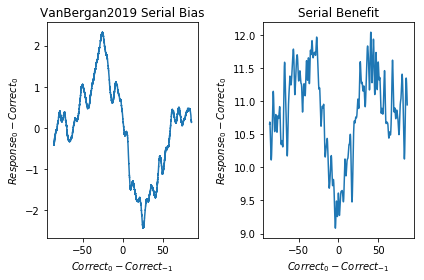

In [211]:
# plt.plot(seq,E,'k.')
d = seq[1:] - seq[:-1]
d[np.abs(d)>90] -=180*np.sign(d[np.abs(d)>90])
Eu = E[1:]
l_win = 2000

# cwin = np.ones(l_win)/l_win
cwin = gauss(np.linspace(-2,2,l_win))
cwin2 = gauss(np.linspace(-5,5,l_win))
cwin/=np.sum(cwin)
cwin2/=np.sum(cwin2)

order = np.argsort(d)

E_out = np.convolve(Eu[order],cwin,mode='valid')
aE_out = np.convolve(np.abs(Eu[order]),cwin2,mode='valid')
d_out = np.convolve(d[order],cwin,mode='valid')

plt.subplot(121)
plt.plot(d_out,E_out)
plt.xlabel('$Correct_0 - Correct_{-1}$')
plt.ylabel('$Response_0 - Correct_{0}$')
plt.title('VanBergan2019 Serial Bias')
plt.subplot(122)

plt.plot(d_out,aE_out)
plt.xlabel('$Correct_0 - Correct_{-1}$')
plt.ylabel('$Response_0 - Correct_{0}$')
plt.title('Serial Benefit')
plt.tight_layout()
plt.show()

In [212]:
# MVP
n_step = 5000 # 
s_0 = np.linspace(0,180,n_step)
N = 5000 # n trials
kappa = 5 # concentration of sensory error

def angle(s_0,s_1):
    d = s_0-s_1
    d[np.abs(d)>90]-= 180*np.sign(d[np.abs(d)>90])
    return d

def c(s_0,s_1=90,lam=10,gamma=2): ## eq 7
    full = np.exp(-1/(2*lam**2)*np.abs(angle(s_0,s_1))**gamma)
    return full/np.sum(full)

def cf(s_0,s_1=90,lam=10,gamma=2,p_same=0.9): ## eq 6
    return p_same*c(s_0,s_1,lam,gamma) + (1-p_same)*(1/n_step)

def pm(s_0,s_1,sensoryNoise): ## eq. 10
    full = np.exp(-1/(2*sensoryNoise**2)*np.abs(angle(s_0,s_1))**2)
    return full/np.sum(full)
def gauss(x,mu=0,sig=1): return 1/np.sqrt(2*pi*sig**2)*np.exp(-((x-mu)**2)/(2*sig**2)) # for convolution


def run_model_SD():
    seq = np.random.randint(0,180,N)
    sensory = np.random.vonmises((seq-90)/90*pi,kappa)*90/pi+90
    inferred_ori = np.zeros(N)
    
    for i in range(N):
        if i ==0:
            prior = cf(s_0,sensory[-1]) # need to start with something
        else:
            prior = cf(s_0,inferred_ori[i-1])
        sensory_estimate = pm(s_0,sensory[i],sensoryNoise)
        ps_m = prior * sensory_estimate
        ps_m /= np.sum(ps_m)
        decoded_ori = np.argmax(ps_m) # could use circ_mean
        inferred_ori[i] = s_0[decoded_ori]
    return seq,inferred_ori

def quick_view_sd(seq,inferred_ori,l_conv=100):
    E = angle(inferred_ori,seq)
    d = seq[1:] - seq[:-1]
    d[np.abs(d)>90] -=180*np.sign(d[np.abs(d)>90])
    Eu = E[1:]
    order = np.argsort(d)
    
    conv_win = gauss(np.linspace(-2,2,l_conv))
    conv_win/=np.sum(conv_win)
    
    E_out = np.convolve(Eu[order],cwin,mode='valid')
    aE_out = np.convolve(np.abs(Eu[order]),cwin2,mode='valid')
    d_out = np.convolve(d[order],cwin,mode='valid')

    return d_out,E_out,aE_out

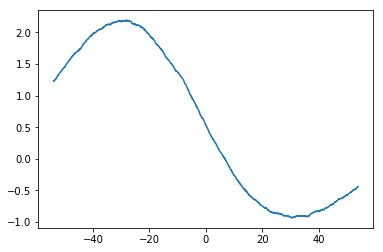

In [213]:
seq,inferred_ori = run_model_SD()
out = quick_view_sd(seq,inferred_ori,l_conv=50)
plt.plot(out[0],out[1])

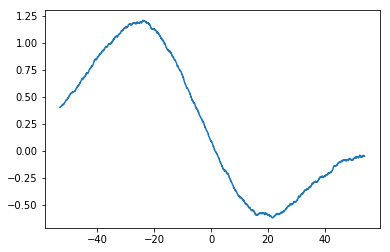

In [197]:
# plt.plot(out[0],out[1],'k.')
